In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [4]:
format_plots()
c = PlotConfig()

In [5]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [6]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [7]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

In [8]:
# avarage per age or session
m_df= male_df.groupby(['age','uuid']).mean()
avg_m_df = male_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [9]:
## clustering from win

In [10]:
norm_df = m_norm
df=male_df

In [11]:
km = KMeans(n_clusters=4, random_state=0)
lbls = km.fit_predict(norm_df.T)
syll_lbl_df = pd.DataFrame({"syll": df.columns, "lbl": lbls})

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
# sort syllables by usage within cluster
cluster_avgs = df.T.groupby(lbls).mean().T.mean().sort_values(ascending=False)
new_map_order = dict(map(reversed, enumerate(cluster_avgs.index)))
cluster_avgs

3    0.020666
1    0.020455
2    0.011006
0    0.009242
dtype: float64

In [13]:
df_with_cluster = df.T
df_with_cluster = df_with_cluster.set_index([pd.Index(lbls, name='labels').map(new_map_order), pd.Index(df_with_cluster.index, name="syllables")])

syllables        0         5         16        18        24        25  \
age                                                                     
4          0.165141  0.105755  0.124495  0.230685  0.149378  0.120281   
8          0.219821  0.090237  0.109776  0.136709  0.285848  0.183002   
12         0.243457  0.160765  0.198083  0.236816  0.247231  0.302842   
16         0.249688  0.211501  0.137399  0.142300  0.246617  0.155058   
20         0.271156  0.218594  0.215703  0.121835  0.205313  0.183208   
24         0.233744  0.314099  0.269414  0.268506  0.218915  0.401152   
28         0.180662  0.260126  0.418750  0.127687  0.280668  0.190732   
32         0.301597  0.328013  0.259090  0.194401  0.211556  0.276257   
36         0.256682  0.354621  0.353310  0.195846  0.389596  0.258271   
40         0.282710  0.320119  0.299328  0.197105  0.325119  0.270045   
44         0.266714  0.387109  0.345835  0.208011  0.255706  0.322445   
48         0.255613  0.369585  0.423283  0.203908  

syllables        10        11        12        30        41        42  \
age                                                                     
4          0.372866  0.599106  0.645282  0.131802  0.409861  0.719869   
8          0.593203  0.606061  0.706212  0.296607  0.222247  0.516927   
12         0.395519  0.414773  0.341148  0.286545  0.111436  0.397782   
16         0.238589  0.326682  0.227979  0.226219  0.095212  0.254327   
20         0.320952  0.338732  0.248477  0.297866  0.081901  0.242465   
24         0.333462  0.265351  0.249336  0.232232  0.090042  0.203263   
28         0.300933  0.227448  0.173170  0.209198  0.074510  0.163746   
32         0.148404  0.357999  0.232205  0.307101  0.096032  0.261871   
36         0.265525  0.151185  0.178184  0.251646  0.081278  0.102450   
40         0.201037  0.175660  0.154733  0.243377  0.088455  0.109875   
44         0.201416  0.251508  0.160059  0.247157  0.065814  0.144227   
48         0.211785  0.142028  0.112288  0.204322  

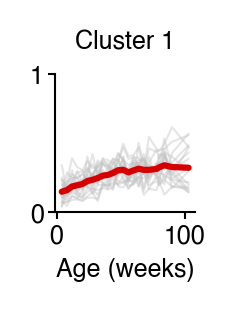

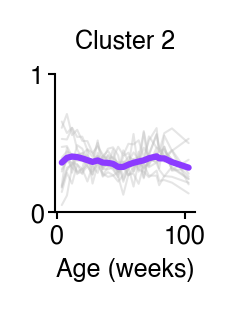

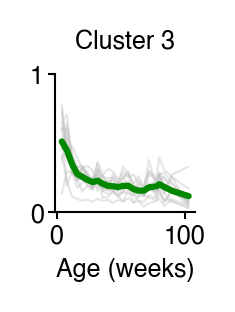

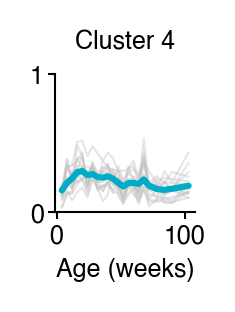

In [14]:
for _lbl, _df in norm_df.T.groupby(list(map(new_map_order.get, lbls))):
    fig = figure(0.6, 0.6)
    ax = fig.gca()
    print(_df.T.groupby("age").mean())
    ax = (
        _df.T.groupby("age")
        .mean()
        .plot(ax=ax, legend=False, color="silver", lw=0.5, alpha=0.4)
    )
    ax.plot(
        _df.T.groupby("age")
        .mean()
        .mean(1)
        .rolling(5, win_type="gaussian", min_periods=1, center=True)
        .mean(std=0.75),
        lw=1.5,
        color=cc.glasbey[_lbl],
    )
    ax.set(ylim=(0, 1), yticks=[0, 1], xlabel="Age (weeks)", title=f"Cluster {_lbl + 1}")
    sns.despine()
    #saver(fig, f"clustered-usage-cluster-{_lbl}")
plt.show()

In [15]:
## K-means silhouette score

In [16]:
ss_d = {}
for i in range(2, 7):
    km = KMeans(n_clusters=i, random_state=0)
    lbls = km.fit_predict(norm_df.T)
    ss = silhouette_score(norm_df.T, lbls)
    ss_d[i] = ss
ss_d

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

{2: 0.11609838931513185,
 3: 0.11339463920424712,
 4: 0.11504869073884928,
 5: 0.10973870919631665,
 6: 0.1087422451944362}

In [17]:
plt.close('all')

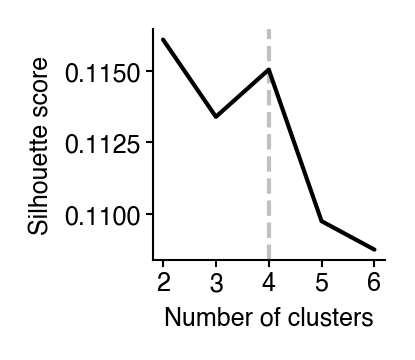

In [18]:
fig = figure(1, 1)
ax = fig.gca()
ax = pd.Series(ss_d).plot(ax=ax, color='k')
ax.set(ylabel='Silhouette score', xlabel='Number of clusters', xticks=range(2, 7))
ax.axvline(4, color='silver', zorder=-1, ls='--')
sns.despine()
fig.savefig(c.dana_save_path / "fig2"/ 'sill_clusters.pdf')

In [19]:
## my k-means

In [20]:
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 [Index([6, 13, 27, 32, 33, 64, 67, 70, 71, 73, 76, 79, 84, 97, 98], dtype='int16[pyarrow]', name='syllables')]
Cluster 1 [Index([2, 4, 7, 9, 14, 17, 23, 36, 55, 63, 66, 95], dtype='int16[pyarrow]', name='syllables')]
Cluster 2 [Index([10, 11, 12, 30, 41, 42, 49, 52, 53, 60, 62, 69, 85], dtype='int16[pyarrow]', name='syllables')]
Cluster 3 [Index([0, 5, 16, 18, 24, 25, 39, 44, 50, 54, 59, 61, 68, 74, 77, 83, 90, 93], dtype='int16[pyarrow]', name='syllables')]


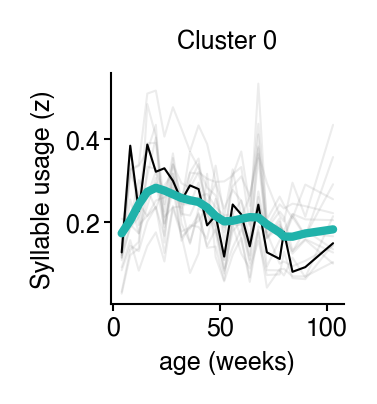

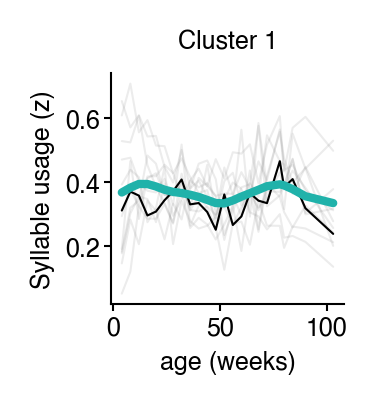

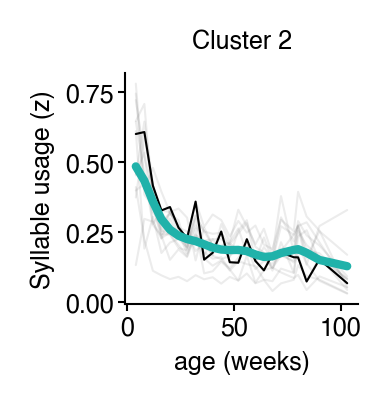

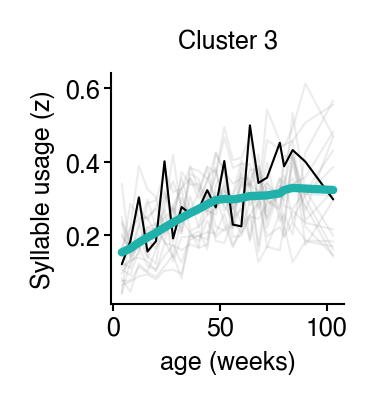

In [37]:
n_clusters = 4
sigma=1.25
sample = [17,11,32,25]
km = KMeans(n_clusters=n_clusters, random_state=0)
clusters = km.fit_predict(m_norm.T)
for i in range(n_clusters):
    fig = figure(1, 1)
    tmp = m_norm.iloc[:, clusters == i].groupby('age').mean()
    print(f'Cluster {i}', [tmp.columns])
    plt.plot(tmp, c='gray', lw=0.5, alpha=0.15,
             #linestyle='--',
            )
    csyll = [number for number in sample if number in tmp.columns]
    plt.plot(tmp[csyll], c='black', lw=0.5)
    m = tmp.mean(1)
    plt.plot(pd.Series(gaussian_filter(m, sigma=sigma), index=tmp.index), c='#20B2AA', lw=2)
    plt.title(f'Cluster {i}')
    plt.xlabel('age (weeks)')
    plt.ylabel('Syllable usage (z)')
    #plt.ylim([0,1])
    sns.despine()
    fig.savefig(c.dana_save_path / "fig2"/ f'male_cluster-{i}.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

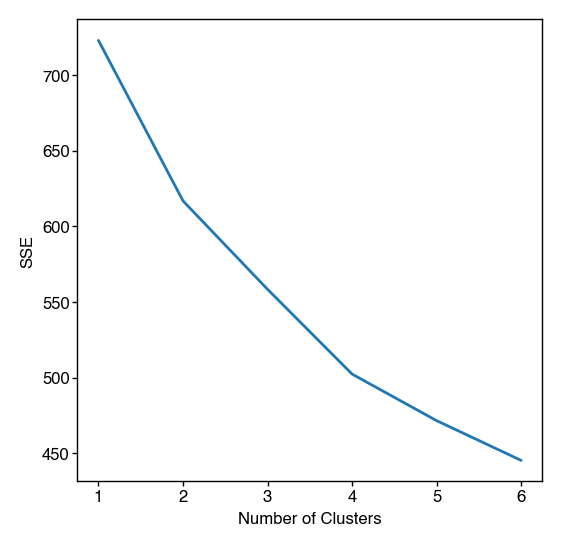

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

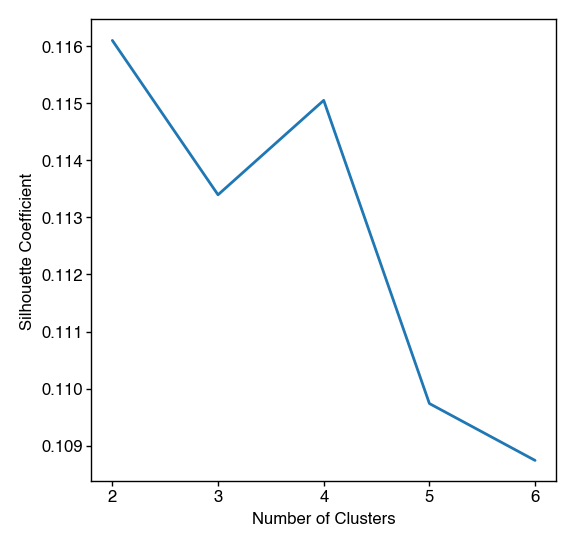

In [22]:
# A list holds the SSE values for each k
sse = []
nclust=6
for k in range(1, nclust+1):
    km = KMeans(n_clusters=k, random_state=0)
    km.fit_predict(m_norm.T)
    sse.append(km.inertia_)

#plt.style.use("fivethirtyeight")
plt.plot(range(1, nclust+1), sse)
plt.xticks(range(1, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# figure out elbow point
#kl = KneeLocator(range(1, nclust+1), sse, curve="convex", direction="decreasing")
#print('elbow point: SSE ', kl.elbow)

# second method
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, nclust+1):
    km = KMeans(n_clusters=k, random_state=0)
    km.fit_predict(m_norm.T)
    score = silhouette_score(m_norm.T, km.labels_)
    silhouette_coefficients.append(score)

#kl = KneeLocator(range(2, nclust+1), silhouette_coefficients, curve="convex", direction="decreasing")
#print('elbow point: sill ', kl.elbow)

#plt.style.use("seaborn")
plt.plot(range(2, nclust+1), silhouette_coefficients)
plt.xticks(range(2, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [23]:
m_norm

syllables                                       0         2         4   \
age uuid                                                                 
4   055b68ad-b41d-4725-9d54-c8992d92934c  0.278761  0.320459  0.071916   
    06852811-14ea-4fe3-8f6e-81bbd1ead951  0.174950  0.177625  0.013939   
    2bb5e7fa-02cd-4694-accf-fed9651b1beb  0.140997  0.098616  0.044934   
    30315149-532f-4d6a-b3c9-b1dcd1e707fe  0.172235  0.171629  0.054889   
    32221902-9ee7-4d36-a7f4-e76375e3084e  0.293038  0.215743  0.024576   
...                                            ...       ...       ...   
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278  0.226627  0.249976  0.762358   
    d344c424-2188-4a5b-b45e-50818128127f  0.067345  0.177266  0.515086   
    dff86510-b65f-4713-aa22-0a4e95f53c23  0.150150  0.150563  0.632695   
    e53d5526-2371-42c1-ab8b-4550d658df60  0.023131  0.088719  0.132687   
    f16bd29c-0284-4226-ab85-ff008abb01e4  0.129621  0.033423  0.076716   

syllables                                       5         6         7   \
age uuid                                                                 
4   055b68ad-b41d-4725-9d54-c8992d92934c  0.105180  0.113907  0.324790   
    06852811-14ea-4fe3-8f6e-81bbd1ead951  0.080805  0.107232  0.121255   
    2bb5e7fa-02cd-4694-accf-fed9651b1beb  0.121878  0.120990  0.173512   
    30315149-532f-4d6a-b3c9-b1dcd1e707fe  0.116398  0.299108  0.213136   
    32221902-9ee7-4d36-a7f4-e76375e3084e  0.047133  0.113438  0.177961   
...                                            ...       ...       ...   
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278  0.539209  0.000000  0.368950   
    d344c424-2188-4a5b-b45e-50818128127f  0.585639  0.082555  0.617697   
    dff86510-b65f-4713-aa22-0a4e95f53c23  0.272133  0.224964  0.349854   
    e53d5526-2371-42c1-ab8b-4550d658df60  1.000000  0.000000  0.616100   
    f16bd29c-0284-4226-ab85-ff008abb01e4  0.450822  0.022700  0.578019   

syllables                                       9         10        11  \
age uuid                                                                 
4   055b68ad-b41d-4725-9d54-c8992d92934c  0.891106  0.157526  0.823544   
    06852811-14ea-4fe3-8f6e-81bbd1ead951  0.650525  0.222442  0.592286   
    2bb5e7fa-02cd-4694-accf-fed9651b1beb  0.806212  0.525866  0.563928   
    30315149-532f-4d6a-b3c9-b1dcd1e707fe  0.543027  0.462311  0.836219   
    32221902-9ee7-4d36-a7f4-e76375e3084e  0.495309  0.470634  0.592568   
...                                            ...       ...       ...   
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278  0.142611  0.256131  0.031720   
    d344c424-2188-4a5b-b45e-50818128127f  0.000000  0.000000  0.183808   
    dff86510-b65f-4713-aa22-0a4e95f53c23  0.180177  0.141414  0.026270   
    e53d5526-2371-42c1-ab8b-4550d658df60  0.147422  0.000000  0.021853   
    f16bd29c-0284-4226-ab85-ff008abb01e4  0.141695  0.031392  0.000000   

syllables                                       12  ...        77        79  \
age uuid                                            ...                       
4   055b68ad-b41d-4725-9d54-c8992d92934c  0.222979  ...  0.089252  0.039961   
    06852811-14ea-4fe3-8f6e-81bbd1ead951  1.000000  ...  0.000000  0.000000   
    2bb5e7fa-02cd-4694-accf-fed9651b1beb  0.532900  ...  0.047401  0.097019   
    30315149-532f-4d6a-b3c9-b1dcd1e707fe  0.703200  ...  0.024126  0.043208   
    32221902-9ee7-4d36-a7f4-e76375e3084e  0.798808  ...  0.000000  0.039797   
...                                            ...  ...       ...       ...   
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278  0.105745  ...  0.253960  0.303218   
    d344c424-2188-4a5b-b45e-50818128127f  0.000000  ...  0.150933  0.318583   
    dff86510-b65f-4713-aa22-0a4e95f53c23  0.046707  ...  0.196302  0.286992   
    e53d5526-2371-42c1-ab8b-4550d658df60  0.000000  ...  0.000000  0.437694   
    f16bd29c-0284-4226-ab85-ff008abb01e4  0.025921  ...  0.062252  0.573375   

syllables                                       83        84        85  \
age uuid 

In [24]:
c = PlotConfig()
#cg.savefig(c.dana_save_path / "fig2"/ 'male_syll_over_time_all_sessions.pdf', bbox_inches='tight')

In [25]:
# get labels and data fot plottinh
data_labels = avg_m_norm.index.get_level_values('age').to_numpy()
data = m_norm.to_numpy()